In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


torch.Size([256, 3, 192, 144])


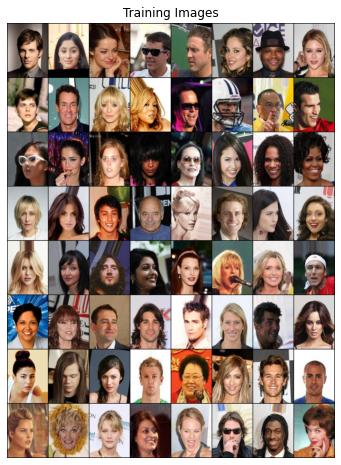

In [20]:
# load image dataset
data_path = r"C:\Users\simon\Documents\Code\programming_experience\neural_networks\data\celebrity_dataset"

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(192, 144)), # aspect ratio 4:3
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4
)

# plot some training images
image_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(image_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
print(np.shape(image_batch[0]))

In [23]:
# 192 = 2 x 2 x 2 x 2 x 3 x 4
# 144 = 2 x 2 x 2 x 2 x 3 x 3

class Generator(nn.Module):
    def __init__(self, size_latent_vector: int, size_feature_maps: int, image_channels: int = 3):
        super().__init__()
        self.model = nn.Sequential(
            # input going into convo
            nn.ConvTranspose2d(
                in_channels=size_latent_vector, 
                out_channels=size_feature_maps*8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            # out = (size_feature_maps x 8) x 4 x 4
            nn.BatchNorm2d(
                num_features=size_feature_maps*8,
                track_running_stats=False
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=size_feature_maps*8,
                out_channels=size_feature_maps*4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            # out = (size_feature_maps x 4) x 8 x 8
            nn.BatchNorm2d(
                num_features=size_feature_maps*4,
                track_running_stats=False
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=size_feature_maps*4,
                out_channels=size_feature_maps*2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            # out = (size_feature_maps x 2) x 16 x 16
            nn.BatchNorm2d(
                num_features=size_feature_maps*2,
                track_running_stats=False
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=size_feature_maps*2,
                out_channels=size_feature_maps,
                kernel_size=3,
                stride=3,
                padding=0,
                bias=False
            ),
            # out = size_feature_maps x 48 x 48
            nn.BatchNorm2d(
                num_features=size_feature_maps,
                track_running_stats=False
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                in_channels=size_feature_maps,
                out_channels=image_channels,
                kernel_size=(4, 3),
                stride=(4, 3),
                padding=(0, 0),
                bias=False
            ),
            # out = 3 x 192 x 144
            nn.Tanh()
            # output size image_channels x image_height x image_width
        )
    def forward(self, input):
        output = self.model(input)
        return output

In [37]:
generator = Generator(
    size_latent_vector=100, 
    size_feature_maps=64, 
    image_channels=3
).to(device=device)

print(generator.model)

# num_batches x size_latent_vector x 1 x 1
x = torch.rand(64, 100, 1, 1).to(device=device)
out = generator(x)
print("Input Shape: ", x.shape)
print("Output Shape: ", out.shape)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 3), stride=(4, 3), bias=False)
  (13): Tanh()
)
Input Shape:  torch.Size([64, 100, 1, 1])
Output Shape:  torch.Size([64, 3, 192, 